In [1]:
# CTRL + A then CTRL + / to uncomment
# CLONE PROJECT TO TRAIN IN GOOGLE COLAB
import os
if os.path.isdir('/content/nature_multilabel_image_classification'):
  !rm -rf '/content/nature_multilabel_image_classification'
  
!git clone https://github.com/WoradeeKongthong/nature_multilabel_image_classification.git

if not os.getcwd() == '/content/nature_multilabel_image_classification' :
  %cd /content/nature_multilabel_image_classification

!pwd

Cloning into 'nature_multilabel_image_classification'...
remote: Enumerating objects: 2059, done.
remote: Counting objects: 100% (2059/2059), done.
remote: Compressing objects: 100% (2047/2047), done.
remote: Total 2059 (delta 19), reused 2037 (delta 7), pack-reused 0
Receiving objects: 100% (2059/2059), 152.02 MiB | 27.40 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/nature_multilabel_image_classification
/content/nature_multilabel_image_classification


In [2]:
# prepared dataset
dataset_path = 'data/nature_data.npz'

# saved model name
model_name = 'best_pretrained_ResNet50.h5'

# Nature Image Classification (Multi-labels)

## Objective 
To learn tags given to each image.  
There are 5 tags;  
- desert  
- mountains  
- sea  
- sunset  
- trees  

## Dataset
source : https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip?dl=0  
(You can follow the tutorial in this blog https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24)

## Approach
Baseline model : CNN model with 1,2 or 3 VGG block(s)  

Improved model 
- dropout
- data augmentation

## Load dataset from file

In [3]:
import numpy as np

In [4]:
# load data
data = np.load(dataset_path)
X, y = data['arr_0'], data['arr_1']
print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (2000, 128, 128, 3)
y shape :  (2000, 5)


## Create train and test set
(Note : validation set will be created with ImageDataGenerator)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [7]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print()
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (1600, 128, 128, 3)
y_train shape :  (1600, 5)

X_test shape :  (400, 128, 128, 3)
y_test shape :  (400, 5)


## Create data generator without data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

## fbeta score function for multi-label problem

In [10]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [11]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Baseline Model

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

Epoch 1/200
64/64 [==============================] - 40s 108ms/step - loss: 0.6132 - fbeta: 0.7442 - val_loss: 0.2652 - val_fbeta: 0.7855
Epoch 2/200
64/64 [==============================] - 6s 91ms/step - loss: 0.1223 - fbeta: 0.9131 - val_loss: 0.2902 - val_fbeta: 0.8199
Epoch 3/200
64/64 [==============================] - 6s 90ms/step - loss: 0.0502 - fbeta: 0.9675 - val_loss: 0.3362 - val_fbeta: 0.8127
Epoch 4/200
64/64 [==============================] - 6s 91ms/step - loss: 0.0219 - fbeta: 0.9854 - val_loss: 0.3125 - val_fbeta: 0.8468
Epoch 5/200
64/64 [==============================] - 6s 91ms/step - loss: 0.0176 - fbeta: 0.9930 - val_loss: 0.3520 - val_fbeta: 0.8365
Epoch 6/200
64/64 [==============================] - 6s 92ms/step - loss: 0.0124 - fbeta: 0.9948 - val_loss: 0.3560 - val_fbeta: 0.8464
Epoch 7/200
64/64 [==============================] - 6s 91ms/step - loss: 0.0077 - fbeta: 0.9971 - val_loss: 0.3490 - val_fbeta: 0.8381
Epoch 8/200
64/64 [===========================

In [16]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

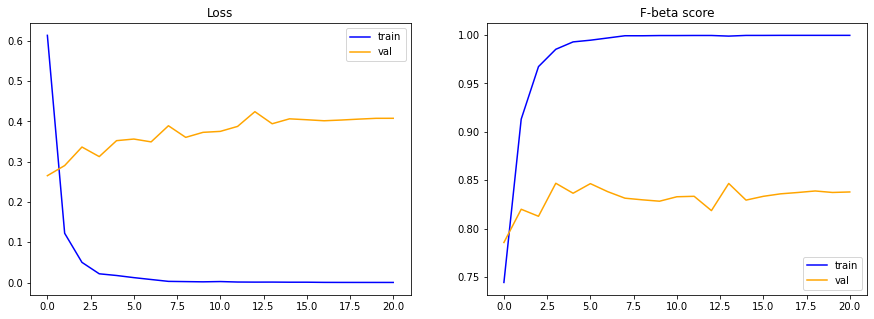

Model F-beta score :  0.8585315942764282


In [17]:
baseline_perf = evaluate_model(history)

Note : overfitting

## Improved Models

### model 1 : set last block as trainable

Epoch 1/200
64/64 [==============================] - 12s 113ms/step - loss: 0.5152 - fbeta: 0.7657 - val_loss: 0.3780 - val_fbeta: 0.8196
Epoch 2/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0992 - fbeta: 0.9343 - val_loss: 0.2707 - val_fbeta: 0.8341
Epoch 3/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0285 - fbeta: 0.9854 - val_loss: 0.2858 - val_fbeta: 0.8267
Epoch 4/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0107 - fbeta: 0.9953 - val_loss: 0.3071 - val_fbeta: 0.8327
Epoch 5/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0042 - fbeta: 0.9991 - val_loss: 0.3041 - val_fbeta: 0.8592
Epoch 6/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0019 - fbeta: 0.9998 - val_loss: 0.3219 - val_fbeta: 0.8587
Epoch 7/200
64/64 [==============================] - 6s 94ms/step - loss: 0.0011 - fbeta: 0.9998 - val_loss: 0.3251 - val_fbeta: 0.8538
Epoch 8/200
64/64 [===========================

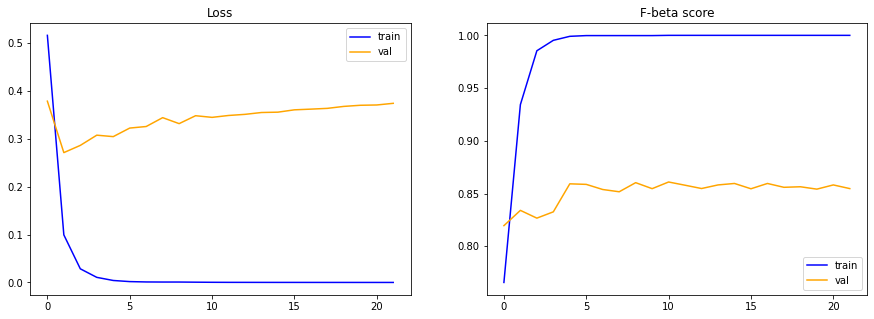

Model F-beta score :  0.8648827075958252


In [18]:
# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model1_perf = evaluate_model(history)

Note : overfitting, the performance is little higher than baseline model

### model 2 : Baseline + dropout layer

Epoch 1/200
64/64 [==============================] - 11s 111ms/step - loss: 0.8153 - fbeta: 0.6779 - val_loss: 0.2692 - val_fbeta: 0.8057
Epoch 2/200
64/64 [==============================] - 6s 92ms/step - loss: 0.2066 - fbeta: 0.8453 - val_loss: 0.2341 - val_fbeta: 0.8310
Epoch 3/200
64/64 [==============================] - 6s 92ms/step - loss: 0.1526 - fbeta: 0.8832 - val_loss: 0.2373 - val_fbeta: 0.8193
Epoch 4/200
64/64 [==============================] - 6s 93ms/step - loss: 0.1378 - fbeta: 0.9058 - val_loss: 0.2266 - val_fbeta: 0.8329
Epoch 5/200
64/64 [==============================] - 6s 92ms/step - loss: 0.1065 - fbeta: 0.9180 - val_loss: 0.2275 - val_fbeta: 0.8430
Epoch 6/200
64/64 [==============================] - 6s 92ms/step - loss: 0.0892 - fbeta: 0.9345 - val_loss: 0.2401 - val_fbeta: 0.8409
Epoch 7/200
64/64 [==============================] - 6s 92ms/step - loss: 0.0751 - fbeta: 0.9458 - val_loss: 0.2491 - val_fbeta: 0.8392
Epoch 8/200
64/64 [===========================

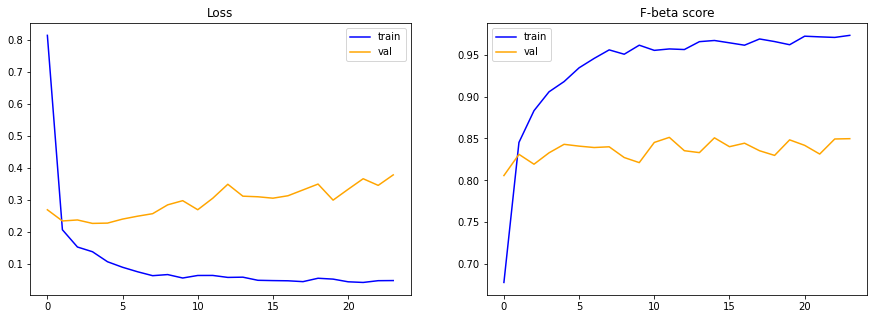

Model F-beta score :  0.8441362977027893


In [19]:
# create image data generator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)

# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model2_perf = evaluate_model(history)

Note : over fitting still occurs, the performance is higher than baseline model

### model 3 : Baseline model + data augmentation

Epoch 1/200
64/64 [==============================] - 14s 155ms/step - loss: 0.7666 - fbeta: 0.5171 - val_loss: 0.4363 - val_fbeta: 0.5154
Epoch 2/200
64/64 [==============================] - 9s 135ms/step - loss: 0.3423 - fbeta: 0.6751 - val_loss: 0.3997 - val_fbeta: 0.6741
Epoch 3/200
64/64 [==============================] - 9s 134ms/step - loss: 0.2862 - fbeta: 0.7361 - val_loss: 0.3227 - val_fbeta: 0.6942
Epoch 4/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2614 - fbeta: 0.7808 - val_loss: 0.3150 - val_fbeta: 0.7640
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.2222 - fbeta: 0.8077 - val_loss: 0.2914 - val_fbeta: 0.7519
Epoch 6/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2029 - fbeta: 0.8284 - val_loss: 0.3272 - val_fbeta: 0.7238
Epoch 7/200
64/64 [==============================] - 9s 133ms/step - loss: 0.2080 - fbeta: 0.8208 - val_loss: 0.2547 - val_fbeta: 0.8034
Epoch 8/200
64/64 [=====================

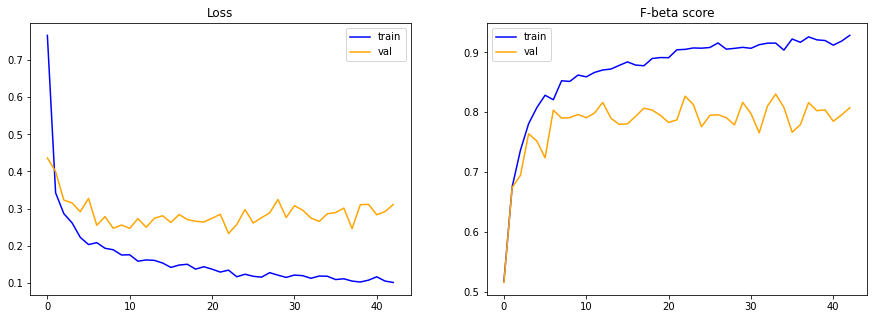

Model F-beta score :  0.8540188074111938


In [20]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='sigmoid')(class1)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model3_perf = evaluate_model(history)

Note : 

### model 4 : Baseline model + data augmentation + dropout layers

Epoch 1/200
64/64 [==============================] - 14s 157ms/step - loss: 0.8828 - fbeta: 0.4864 - val_loss: 0.3877 - val_fbeta: 0.6692
Epoch 2/200
64/64 [==============================] - 9s 136ms/step - loss: 0.4495 - fbeta: 0.5250 - val_loss: 0.3271 - val_fbeta: 0.6956
Epoch 3/200
64/64 [==============================] - 9s 136ms/step - loss: 0.4134 - fbeta: 0.5563 - val_loss: 0.3231 - val_fbeta: 0.7111
Epoch 4/200
64/64 [==============================] - 9s 135ms/step - loss: 0.4060 - fbeta: 0.5413 - val_loss: 0.3002 - val_fbeta: 0.7091
Epoch 5/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3672 - fbeta: 0.5761 - val_loss: 0.3268 - val_fbeta: 0.6844
Epoch 6/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3858 - fbeta: 0.5836 - val_loss: 0.2966 - val_fbeta: 0.7191
Epoch 7/200
64/64 [==============================] - 9s 136ms/step - loss: 0.3533 - fbeta: 0.6204 - val_loss: 0.3160 - val_fbeta: 0.7441
Epoch 8/200
64/64 [=====================

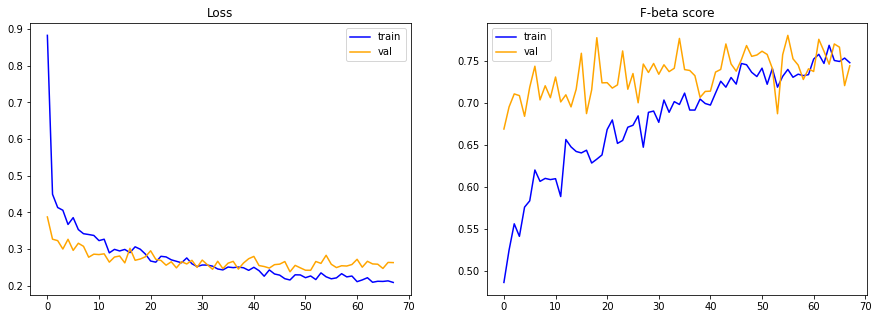

Model F-beta score :  0.7938674092292786


In [24]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.4)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model4_perf = evaluate_model(history)

Note : overfitting is reduced

### model 5 : set last block trainable + data augmentation + dropout layer

Epoch 1/200
64/64 [==============================] - 14s 153ms/step - loss: 0.6966 - fbeta: 0.6067 - val_loss: 0.3894 - val_fbeta: 0.6450
Epoch 2/200
64/64 [==============================] - 9s 133ms/step - loss: 0.3303 - fbeta: 0.7221 - val_loss: 0.3543 - val_fbeta: 0.6592
Epoch 3/200
64/64 [==============================] - 9s 134ms/step - loss: 0.3063 - fbeta: 0.7625 - val_loss: 0.3329 - val_fbeta: 0.7151
Epoch 4/200
64/64 [==============================] - 9s 134ms/step - loss: 0.2629 - fbeta: 0.7682 - val_loss: 0.2866 - val_fbeta: 0.7725
Epoch 5/200
64/64 [==============================] - 9s 134ms/step - loss: 0.2438 - fbeta: 0.7914 - val_loss: 0.2869 - val_fbeta: 0.7687
Epoch 6/200
64/64 [==============================] - 9s 135ms/step - loss: 0.2216 - fbeta: 0.8083 - val_loss: 0.2791 - val_fbeta: 0.7861
Epoch 7/200
64/64 [==============================] - 9s 134ms/step - loss: 0.2290 - fbeta: 0.8142 - val_loss: 0.2850 - val_fbeta: 0.7958
Epoch 8/200
64/64 [=====================

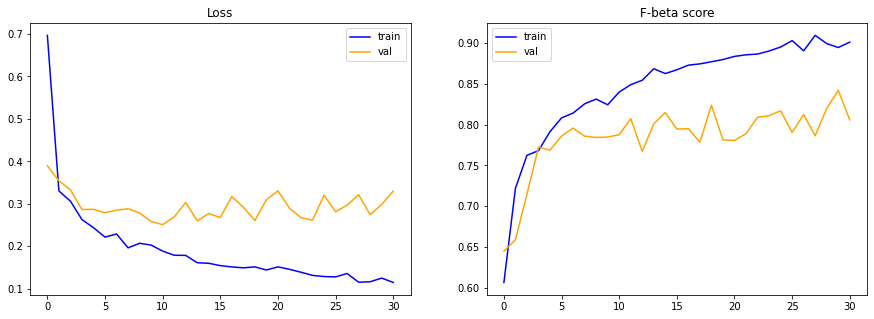

Model F-beta score :  0.8253860473632812


In [22]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# mark last block as trainable
model.get_layer('conv5_block3_3_conv').trainable = True
model.get_layer('conv5_block3_3_bn').trainable = True
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es],
                    epochs=200)

model5_perf = evaluate_model(history)

Note : overfitting, but the performance (fbeta score) is high

## Model performance

In [23]:
print('Baseline model : ', baseline_perf)
print('model 1 : ', model1_perf)
print('model 2 : ', model2_perf)
print('model 3 : ', model3_perf)
print('model 4 : ', model4_perf)
print('model 5 : ', model5_perf)

Baseline model :  0.8585315942764282
model 1 :  0.8648827075958252
model 2 :  0.8441362977027893
model 3 :  0.8540188074111938
model 4 :  0.8297007083892822
model 5 :  0.8253860473632812


Note : only model 4 is not high overfitting

## Finalize model 4
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='training', seed=123)
val_iter = train_gen.flow(X_train, y_train, batch_size=batch_size, subset='validation', seed=123)
test_iter = test_gen.flow(X_test, y_test, batch_size=1, shuffle=False)

# create model

# load ResNet50 model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
output = Dense(5, activation='sigmoid')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# create model checkpoint to save the model
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit model
history = model.fit(train_iter, 
                    steps_per_epoch=len(train_iter),
                    validation_data=val_iter,
                    validation_steps=len(val_iter), 
                    callbacks=[es, mc],
                    epochs=300)
final_model_perf = evaluate_model(history)

Epoch 1/300
64/64 [==============================] - 13s 154ms/step - loss: 1.6461 - val_loss: 0.3651

Epoch 00001: val_loss improved from inf to 0.36505, saving model to best_pretrained_ResNet50.h5
Epoch 2/300
64/64 [==============================] - 9s 136ms/step - loss: 0.4041 - val_loss: 0.3200

Epoch 00002: val_loss improved from 0.36505 to 0.32003, saving model to best_pretrained_ResNet50.h5
Epoch 3/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3343 - val_loss: 0.2962

Epoch 00003: val_loss improved from 0.32003 to 0.29620, saving model to best_pretrained_ResNet50.h5
Epoch 4/300
64/64 [==============================] - 9s 135ms/step - loss: 0.3527 - val_loss: 0.2969

Epoch 00004: val_loss did not improve from 0.29620
Epoch 5/300
64/64 [==============================] - 9s 135ms/step - loss: 0.2949 - val_loss: 0.3315

Epoch 00005: val_loss did not improve from 0.29620
Epoch 6/300
64/64 [==============================] - 9s 135ms/step - loss: 0.2848 - val_los

## Evaluate model

In [ ]:
# print model score
final_model_fbeta = model.evaluate(test_iter)[1]
print('final_model_fbeta : ', final_model_fbeta)

final_model_fbeta :  0.84483045


## Save model to local machine

In [ ]:
# load saved model file to local machine
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>